### 03 — Baseline Matrix Factorization (SVD / SVD++)
Baseline collaborative filtering using Surprise.

**Goals**
1. Train SVD / SVD++ on `ratings_train.csv`.
2. Evaluate RMSE/MAE on `ratings_valid.csv`.
3. Compute Precision@K / Recall@K via top-10 recommendations.

In [ ]:
import sys
from pathlib import Path
import pandas as pd
from surprise import dump
import matplotlib.pyplot as plt

BASE = Path.cwd().parent
sys.path.append(str(BASE / 'src'))

from svd_model import (
    SVD,
    build_trainset,
    fit_svd,
    predict_pairs,
    rating_metrics,
    grid_search_svd,
    precision_recall_at_k,
    to_prediction_tuples,
    recommend_top_k
)

PROC = BASE / 'data' / 'processed'
MODELS = BASE / 'models'
MODELS.mkdir(exist_ok=True)

train_path = PROC / 'ratings_train.csv'
valid_path = PROC / 'ratings_valid.csv'

assert train_path.exists() and valid_path.exists(), "Run 02_preprocessing.ipynb first to create processed splits."

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)

print('Train shape:', train_df.shape, ' Valid shape:', valid_df.shape)
print('Unique users (train):', train_df.userId.nunique(), ' Unique movies (train):', train_df.movieId.nunique())


Train shape: (31316, 7)  Valid shape: (3669, 7)
Unique users (train): 479  Unique movies (train): 426


In [20]:
# Sample only the most active users for faster experimentation
SAMPLE_USERS = 1000  # set to None to disable sampling

if SAMPLE_USERS:
    active_users = train_df['userId'].value_counts().index[:SAMPLE_USERS]
    # Only get active users's data
    train_df = train_df[train_df['userId'].isin(active_users)]
    valid_df = valid_df[valid_df['userId'].isin(active_users)]
    print('After sampling -> Train:', train_df.shape, ' Valid:', valid_df.shape)

After sampling -> Train: (31316, 7)  Valid: (3669, 7)


In [21]:
# Converts the training DataFrame into a format that the recommendation model can understand.
trainset, reader = build_trainset(train_df)
# Converts the validation DataFrame (valid_df) into a list of tuples used for prediction.
valid_pairs = to_prediction_tuples(valid_df)

print('Trainset size (n_ratings):', trainset.n_ratings)
print('n_users:', trainset.n_users, ' n_items:', trainset.n_items)


Trainset size (n_ratings): 31316
n_users: 479  n_items: 426


In [22]:
# Defines a dictionary of hyperparameters for the SVD model
svd_params = dict(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
algo_svd = fit_svd(trainset, **svd_params)
# Trained SVD model to predict ratings for all (user, item) pairs in the validation dataset
preds_valid_svd = predict_pairs(algo_svd, valid_pairs)
metrics_svd = rating_metrics(preds_valid_svd)
rmse_svd = metrics_svd.rmse
mae_svd = metrics_svd.mae

print(f"SVD validation RMSE: {rmse_svd:.4f}")
print(f"SVD validation MAE: {mae_svd:.4f}")


SVD validation RMSE: 0.8479
SVD validation MAE: 0.6495


In [23]:
# The grid search will try all possible combinations  4 × 4 × 4 × 4 = 256 different models.
param_grid = {
  'n_factors': [32, 64, 96, 128, 160],
  'n_epochs':  [10, 20, 30, 40],
  'lr_all':    [0.001, 0.003, 0.005, 0.008],
  'reg_all':   [0.005, 0.01, 0.02, 0.04]
}

# Do cross validate and get the avg RSME
gs = grid_search_svd(train_df, param_grid, algo_cls=SVD, reader=reader)

print('Best RMSE:', gs.best_score['rmse'])
print('Best params:', gs.best_params['rmse'])

# Use the best hyperparameter to get best model
best_svd = fit_svd(trainset, **gs.best_params['rmse'])
preds_best = predict_pairs(best_svd, valid_pairs)
metrics_best = rating_metrics(preds_best)
rmse_best = metrics_best.rmse
mae_best = metrics_best.mae

print(f"Best-model validation RMSE: {rmse_best:.4f}")
print(f"Best-model validation MAE: {mae_best:.4f}")


Best RMSE: 0.8331802655313822
Best params: {'n_factors': 96, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.04}
Best-model validation RMSE: 0.8315
Best-model validation MAE: 0.6361


#### Persist Best SVD Model
Save the top-performing Surprise SVD checkpoint for downstream evaluation notebooks.

In [ ]:
best_svd_path = MODELS / 'svd_baseline.dump'
dump.dump(str(best_svd_path), algo=best_svd)
print('Saved best SVD checkpoint to', best_svd_path)

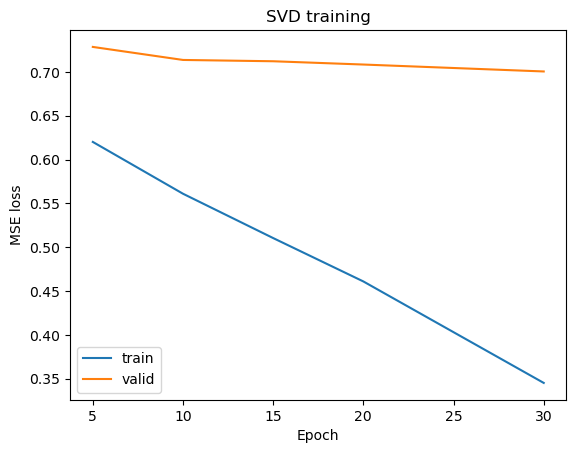

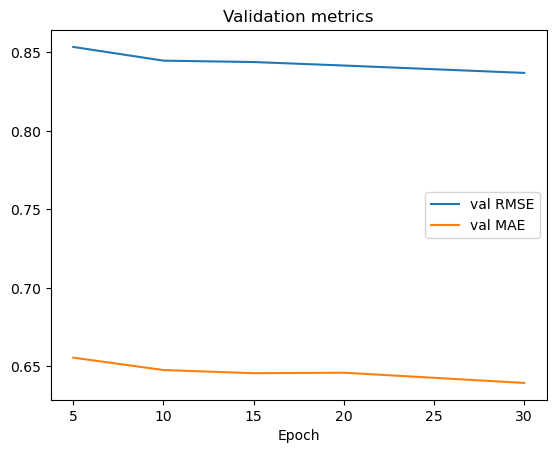

In [29]:
metrics_df = pd.DataFrame([
    {"model": "Baseline SVD", "rmse": rmse_svd, "mae": mae_svd},
    {"model": "Best SVD", "rmse": rmse_best, "mae": mae_best},
])

base_params = dict(gs.best_params['rmse'])
epoch_grid = [5, 10, 15, 20, 30]
train_eval_df = train_df.sample(n=min(len(train_df), 20000), random_state=42)
train_pairs_sample = to_prediction_tuples(train_eval_df)

history = {"epoch": [], "train_rmse": [], "val_rmse": [], "val_mae": []}
for n_epochs in epoch_grid:
    params = {**base_params, "n_epochs": n_epochs}
    model = fit_svd(trainset, **params)

    train_preds = predict_pairs(model, train_pairs_sample)
    train_rmse = rating_metrics(train_preds).rmse

    val_preds = predict_pairs(model, valid_pairs)
    val_metrics = rating_metrics(val_preds)

    history["epoch"].append(n_epochs)
    history["train_rmse"].append(train_rmse)
    history["val_rmse"].append(val_metrics.rmse)
    history["val_mae"].append(val_metrics.mae)

history_df = pd.DataFrame(history)
history_df["train_loss"] = history_df["train_rmse"] ** 2
history_df["val_loss"] = history_df["val_rmse"] ** 2

plt.figure()
plt.plot(history_df["epoch"], history_df["train_loss"], label="train")
plt.plot(history_df["epoch"], history_df["val_loss"], label="valid")
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.legend(); plt.title("SVD training"); plt.show()

plt.figure()
plt.plot(history_df["epoch"], history_df["val_rmse"], label="val RMSE")
plt.plot(history_df["epoch"], history_df["val_mae"], label="val MAE")
plt.xlabel("Epoch"); plt.legend(); plt.title("Validation metrics"); plt.show()

In [25]:
K = 10
# ratings ≥ 4.0 are treated as “liked”
THRESHOLD = 4.0

for name, model in [
    ("SVD", algo_svd),
    ("BEST SVD", best_svd),
]:
    p, r = precision_recall_at_k(model, train_df, valid_df, k=K, threshold=THRESHOLD)
    print(f"{name}  Precision@{K}: {p:.4f}, Recall@{K}: {r:.4f}")


SVD  Precision@10: 0.0343, Recall@10: 0.0596
BEST SVD  Precision@10: 0.0330, Recall@10: 0.0537


In [26]:
movies_df = pd.read_csv(PROC / 'movies_enriched.csv', usecols=['movieId', 'title', 'genres'])

sample_user = int(train_df.userId.sample(1, random_state=42).iloc[0])
print(f"Sample user: {sample_user}")

for name, model in zip(
    ["SVD", "Best SVD"],
    [algo_svd, best_svd]
):
    # Get list of movieId
    recs = recommend_top_k(model, sample_user, train_df, 10)

    # Transform to DataFrame and merge movie information
    recs_df = pd.DataFrame(recs, columns=["movieId", "pred_rating"])
    recs_df = recs_df.merge(movies_df, on="movieId", how="left")

    print(f"\n=== {name} Top 10 ===")
    display(recs_df[["movieId", "title", "genres", "pred_rating"]])


Sample user: 591

=== SVD Top 10 ===


,movieId,title,genres,pred_rating
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.688224
1,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.402133
2,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.399498
3,51255,Hot Fuzz (2007),Action|Comedy|Crime|Mystery,4.393573
4,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.359605
5,48516,"Departed, The (2006)",Crime|Drama|Thriller,4.346506
6,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.335013
7,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.333887
8,1276,Cool Hand Luke (1967),Drama,4.308662
9,76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX,4.305362



=== Best SVD Top 10 ===


,movieId,title,genres,pred_rating
0,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,4.441998
1,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.425287
2,68157,Inglourious Basterds (2009),Action|Drama|War,4.378620
3,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,4.369763
4,4011,Snatch (2000),Comedy|Crime|Thriller,4.339799
5,2791,Airplane! (1980),Comedy,4.320926
6,858,"Godfather, The (1972)",Crime|Drama,4.310196
7,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.304872
8,60069,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,4.281288
9,1276,Cool Hand Luke (1967),Drama,4.272162
